In [109]:
import pandas as pd 
import numpy as np 
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet



# Part 1: Data Cleaning

In [91]:
# Weather data
weather = pd.read_csv("/Users/owenk/Downloads/GSB 544 Project Data/NYC Weather data.csv")
weather = weather.rename(columns={
    'STATION': 'Station',
    'NAME': 'Name',
    'DATE': 'Date',
    'AWND': 'Average Wind Speed',
    'PRCP': 'Precipitation',
    'SNOW': 'Snow',
    'SNWD': 'Snow Depth',
    'TMAX': 'Max Temp',
    'TMIN': 'Min Temp',
})
columns_of_interest = ['Station', 'Name', 'Date', 'Average Wind Speed', 'Precipitation', 'Snow', 'Snow Depth', 'Max Temp', 'Min Temp']
weather_fil = weather[columns_of_interest]
weather_fil['Date'] = pd.to_datetime(weather_fil['Date'], errors='coerce')

numeric_cols = ['Average Wind Speed', 'Precipitation', 'Snow', 'Snow Depth', 'Max Temp', 'Min Temp']
weather_fil[numeric_cols] = weather_fil[numeric_cols].apply(pd.to_numeric, errors='coerce')

weather_fil = weather_fil.dropna(subset=['Date'])

weather_fil = weather_fil.reset_index(drop=True)

weather_fil['Year'] = weather_fil['Date'].dt.year
#adding column month_year and year
weather_fil['Month_Year'] = weather_fil['Date'].dt.to_period('M').astype(str)
weather_fil

<positron-console-cell-91>:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
<positron-console-cell-91>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-91>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Station,Name,Date,Average Wind Speed,Precipitation,Snow,Snow Depth,Max Temp,Min Temp,Year,Month_Year
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2016-01-01,7.61,0.00,0.0,0.0,42,34,2016,2016-01
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2016-01-02,6.71,0.00,0.0,0.0,40,32,2016,2016-01
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2016-01-03,7.83,0.00,0.0,0.0,45,35,2016,2016-01
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2016-01-04,8.50,0.00,0.0,0.0,36,14,2016,2016-01
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2016-01-05,5.14,0.00,0.0,0.0,29,11,2016,2016-01
...,...,...,...,...,...,...,...,...,...,...,...
2917,USW00014732,"LAGUARDIA AIRPORT, NY US",2019-12-27,8.95,0.00,0.0,0.0,54,42,2019,2019-12
2918,USW00014732,"LAGUARDIA AIRPORT, NY US",2019-12-28,8.28,0.00,0.0,0.0,50,44,2019,2019-12
2919,USW00014732,"LAGUARDIA AIRPORT, NY US",2019-12-29,8.05,0.29,0.0,0.0,44,38,2019,2019-12
2920,USW00014732,"LAGUARDIA AIRPORT, NY US",2019-12-30,17.90,0.49,0.0,0.0,43,38,2019,2019-12


In [100]:
name_dummies = pd.get_dummies(weather_fil['Name'], prefix='Name')

# Concatenate the binary columns with the original DataFrame
weather_binary = pd.concat([weather_fil, name_dummies], axis=1)

# Drop the original 'Name' column if not needed
weather_binary = weather_binary.drop(columns=['Name'])
weather_binary

,Station,Date,Average Wind Speed,Precipitation,Snow,Snow Depth,Max Temp,Min Temp,Year,Month_Year,"Name_LAGUARDIA AIRPORT, NY US","Name_NY CITY CENTRAL PARK, NY US"
0,USW00094728,2016-01-01,7.61,0.00,0.0,0.0,42,34,2016,2016-01,False,True
1,USW00094728,2016-01-02,6.71,0.00,0.0,0.0,40,32,2016,2016-01,False,True
2,USW00094728,2016-01-03,7.83,0.00,0.0,0.0,45,35,2016,2016-01,False,True
3,USW00094728,2016-01-04,8.50,0.00,0.0,0.0,36,14,2016,2016-01,False,True
4,USW00094728,2016-01-05,5.14,0.00,0.0,0.0,29,11,2016,2016-01,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2917,USW00014732,2019-12-27,8.95,0.00,0.0,0.0,54,42,2019,2019-12,True,False
2918,USW00014732,2019-12-28,8.28,0.00,0.0,0.0,50,44,2019,2019-12,True,False
2919,USW00014732,2019-12-29,8.05,0.29,0.0,0.0,44,38,2019,2019-12,True,False
2920,USW00014732,2019-12-30,17.90,0.49,0.0,0.0,43,38,2019,2019-12,True,False


In [29]:
#Ridership data 
rider = pd.read_excel("/Users/owenk/Downloads/GSB 544 Project Data/Ridership.xlsx", sheet_name="Annual Total")
rider.columns = ['Station', '*', 'Boro', '2018', '2019', '2020', '2021', '2022', '2023']
rider = rider.drop(columns=['Boro'])
rider = rider.drop(columns=['*'])
ridership_clean = rider.melt(
    id_vars=['Station'],
    var_name='Year',
    value_name='Ridership'
)

ridership_clean = ridership_clean[(ridership_clean['Year'] != 2014) & (ridership_clean['Year'] != 2015)]
ridership_clean = ridership_clean.dropna()
ridership_clean

,Station,Year,Ridership
0,"138 St-Grand Concourse (4,5)",2018,9.445980e+05
1,"149 St-Grand Concourse (2,4,5)",2018,3.972763e+06
2,"161 St-Yankee Stadium (B,D,4)",2018,8.392290e+06
3,167 St (4),2018,2.933140e+06
4,"167 St (B,D)",2018,2.022919e+06
...,...,...,...
2578,Brooklyn,2023,2.602115e+08
2579,Bronx,2023,8.230669e+07
2580,Manhattan,2023,6.384509e+08
2581,Queens,2023,1.710290e+08


In [81]:
#MTA KPIs: OTP (Y variable)

kpi = pd.read_csv("/Users/owenk/Downloads/GSB 544 Project Data/MTA_Key_Performance_Indicators__2008-2021 (1).csv")

columns_to_drop = ['Parent Sequence', 'Frequency', 'Desired Change', 'Indicator Unit', 'Decimal Places']
mta_kpi_final = kpi.drop(columns=columns_to_drop)


filtered_data = mta_kpi_final[mta_kpi_final['Indicator Name'].str.contains('OTP | On-Time Performance', case=False, na=False)]
filtered_data['OTP difference'] = filtered_data['Monthly Actual'] - filtered_data['Monthly Target']

tidy_otp = filtered_data.drop(columns = ['YTD Target', 'YTD Actual', 'Monthly Target', 'Monthly Actual', 'Description', 'Category', 'Indicator Sequence'])

tidy_otp['Duplicate_ID'] = tidy_otp.groupby(
    ['Agency Name', 'Period Year', 'Period Month', 'Period', 'Indicator Name']
).cumcount()

# Pivot the DataFrame with the new unique identifier
tidy_otp_pivoted = tidy_otp.pivot(
    index=['Agency Name', 'Period Year', 'Period Month', 'Period', 'Duplicate_ID'],
    columns='Indicator Name',
    values='OTP difference'
).reset_index()

# Drop 'Duplicate_ID' if it's no longer needed
tidy_otp_pivoted = tidy_otp_pivoted.drop(columns='Duplicate_ID')

tidy_otp_pivoted

<positron-console-cell-81>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Indicator Name,Agency Name,Period Year,Period Month,Period,OTP (Terminal) - 1 Line,OTP (Terminal) - 2 Line,OTP (Terminal) - 3 Line,OTP (Terminal) - 4 Line,OTP (Terminal) - 5 Line,OTP (Terminal) - 6 Line,OTP (Terminal) - 7 Line,OTP (Terminal) - A Line,OTP (Terminal) - B Line,OTP (Terminal) - C Line,OTP (Terminal) - D Line,OTP (Terminal) - E Line,OTP (Terminal) - F Line,OTP (Terminal) - G Line,OTP (Terminal) - J Z Line,OTP (Terminal) - L Line,OTP (Terminal) - M Line,OTP (Terminal) - N Line,OTP (Terminal) - Q Line,OTP (Terminal) - R Line,OTP (Terminal) - S Fkln Line,OTP (Terminal) - S Line 42 St.,OTP (Terminal) - S Line Rock,OTP (Terminal) - W Line
0,NYC Transit,2009,6,2009-06,86.80,79.70,63.50,80.60,82.80,84.20,91.20,81.10,91.70,91.70,83.90,80.00,66.60,79.30,94.20,96.20,97.30,91.20,96.50,92.00,99.00,95.20,92.10,96.20
1,NYC Transit,2009,7,2009-07,93.20,81.30,82.60,84.80,84.90,88.20,91.30,81.60,81.60,86.80,81.20,77.80,62.30,79.50,96.70,93.90,98.20,86.90,93.60,87.10,99.90,99.10,93.30,94.00
2,NYC Transit,2009,8,2009-08,84.70,81.40,82.60,85.20,82.70,87.50,93.70,81.90,85.70,89.30,83.00,86.00,76.00,85.50,95.80,97.10,98.10,86.80,93.10,86.80,99.70,97.00,94.90,95.60
3,NYC Transit,2009,9,2009-09,93.90,79.70,78.60,83.00,85.70,89.50,94.60,84.90,93.30,93.10,80.40,90.00,78.30,94.80,98.40,97.70,98.80,90.70,95.90,92.60,99.90,98.90,97.60,97.00
4,NYC Transit,2009,10,2009-10,92.60,73.10,79.80,78.80,76.80,89.60,94.40,79.40,89.90,91.00,77.60,91.60,77.10,87.70,98.60,94.70,99.30,86.90,93.60,89.60,99.20,99.60,93.50,94.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,NYC Transit,2017,8,2017-08,-1.18,-47.09,-24.58,-37.77,-40.90,-12.40,-5.74,-15.97,-19.93,-9.78,-19.05,-19.23,-33.24,2.84,-4.19,17.58,-1.03,-23.69,-8.79,-3.28,24.71,24.09,19.14,-3.11
97,NYC Transit,2017,9,2017-09,-4.55,-47.29,-30.52,-43.01,-48.86,-23.10,3.21,-16.94,-16.53,-14.60,-17.39,-18.34,-30.16,3.93,-5.99,17.85,-0.41,-21.06,-8.66,-6.63,24.92,24.58,18.68,0.56
98,NYC Transit,2017,10,2017-10,-3.07,-44.17,-27.50,-42.06,-50.51,-21.28,-2.15,-20.76,-18.65,-16.77,-18.67,-14.56,-30.54,-1.08,-7.63,17.83,-1.91,-12.25,-4.06,-10.21,24.73,24.39,19.57,-5.09
99,NYC Transit,2017,11,2017-11,-5.43,-50.05,-33.67,-47.97,-49.82,-27.35,-5.79,-25.30,-28.51,-18.71,-29.60,-13.53,-28.63,-4.70,-4.12,21.64,0.96,-9.90,-10.40,-11.10,24.61,23.74,18.72,-4.20


In [82]:
#KPIs other
kpi2 = pd.read_csv("/Users/owenk/Downloads/GSB 544 Project Data/MTA_Key_Performance_Indicators__2008-2021 (1).csv")

columns_to_drop2 = ['Parent Sequence', 'Frequency', 'Desired Change', 'Indicator Unit', 'Decimal Places']
mta_kpi_final2 = kpi2.drop(columns=columns_to_drop)


filtered_data2 = mta_kpi_final2[~mta_kpi_final2['Indicator Name'].str.contains('OTP|On-Time Performance', case=False, na=False)]
filtered_data2['KPI Difference'] = filtered_data2['Monthly Actual'] - filtered_data2['Monthly Target']
filtered_data2['Agency Name'] = "NYC Transit"

tidy_kpi = filtered_data2.drop(columns = ['YTD Target', 'YTD Actual', 'Monthly Target', 'Monthly Actual', 'Description', 'Category', 'Indicator Sequence'])

tidy_kpi['Duplicate_ID'] = tidy_kpi.groupby(
    ['Agency Name', 'Period Year', 'Period Month', 'Period', 'Indicator Name']
).cumcount()

# Pivot the DataFrame with the new unique identifier
tidy_kpi_pivoted = tidy_kpi.pivot(
    index=['Agency Name', 'Period Year', 'Period Month', 'Period', 'Duplicate_ID'],
    columns='Indicator Name',
    values='KPI Difference'
).reset_index()

# Drop 'Duplicate_ID' if it's no longer needed
tidy_kpi_pivoted = tidy_kpi_pivoted.drop(columns='Duplicate_ID')

tidy_kpi_pivoted
#keep: Elevator Availability - Subways, Escalator Availability - Subways,

<positron-console-cell-82>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<positron-console-cell-82>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Indicator Name,Agency Name,Period Year,Period Month,Period,% of Completed Trips - MTA Bus,% of Completed Trips - NYCT Bus,100th Street Depot - % of Completed Trips,126th Street Depot - % of Completed Trips,Baisley Park Depot - % of Completed Trips,Bus Passenger Wheelchair Lift Usage - MTA Bus,Bus Passenger Wheelchair Lift Usage - NYCT Bus,Casey Stengel Depot - % of Completed Trips,Castleton Depot - % of Completed Trips,Charleston Depot - % of Completed Trips,College Point Depot - % of Completed Trips,Collisions with Injury Rate,Collisions with Injury Rate - MTA Bus,Collisions with Injury Rate - NYCT Bus,Customer Accident Injury Rate - MTA Bus,Customer Accident Injury Rate - NYCT Bus,Customer Injury Rate,Customer Injury Rate - Subways,East New York Depot - % of Completed Trips,Eastchester Depot - % of Completed Trips,Elevator Availability,Elevator Availability - Subways,Employee Lost Time Rate,Employee Lost Time Rate - MTA Bus,Employee Lost Time and Restricted Duty Rate,Escalator Availability,Escalator Availability - Subways,Far Rockaway Depot - % of Completed Trips,Flatbush Depot - % of Completed Trips,Fresh Pond Depot - % of Completed Trips,Grand Avenue Depot - % of Completed Trips,Gun Hill Depot - % of Completed Trips,JFK Depot - % of Completed Trips,Jackie Gleason Depot - % of Completed Trips,Jamaica Depot - % of Completed Trips,Kingsbridge Depot - % of Completed Trips,...,Michael J. Quill Depot - % of Completed Trips,Queens Village Depot - % of Completed Trips,Reportable Customer Injury Rate,Spring Creek Depot - % of Completed Trips,Subway Wait Assessment,Subway Wait Assessment - 1 Line,Subway Wait Assessment - 2 Line,Subway Wait Assessment - 3 Line,Subway Wait Assessment - 4 Line,Subway Wait Assessment - 5 Line,Subway Wait Assessment - 6 Line,Subway Wait Assessment - 7 Line,Subway Wait Assessment - A Line,Subway Wait Assessment - B Line,Subway Wait Assessment - C Line,Subway Wait Assessment - D Line,Subway Wait Assessment - E Line,Subway Wait Assessment - F Line,Subway Wait Assessment - G Line,Subway Wait Assessment - J Z Line,Subway Wait Assessment - L Line,Subway Wait Assessment - M Line,Subway Wait Assessment - N Line,Subway Wait Assessment - Q Line,Subway Wait Assessment - R Line,Subway Wait Assessment - S 42 St,Subway Wait Assessment - S Fkln,Subway Wait Assessment - S Rock,Subway Wait Assessment - W Line,Total Paratransit Ridership - NYCT Bus,Total Ridership,Total Ridership - MTA Bus,Total Ridership - NYCT Bus,Total Ridership - Subways,Total Traffic,Ulmer Park Depot - % of Completed Trips,"Wait Assessment - Subways (Inactive, Historic Calculations)",West Farms Depot - % of Completed Trips,Yonkers Depot - % of Completed Trips,Yukon Depot - % of Completed Trips
0,NYC Transit,2008,1,2008-01,-0.07,0.07,-0.24,0.1,0.29,2727.0,78259.0,0.11,-0.22,NaN,-0.13,-0.21,NaN,NaN,NaN,1.41,1.45,0.48,0.08,0.49,2.48,NaN,0.6,-0.96,-0.46,3.30,NaN,-0.29,-0.15,0.01,-0.24,-0.38,0.05,0.04,0.25,-0.19,...,0.18,0.10,1.18,-0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,539952.0,-84015.0,0.0,1480506.0,1205792.0,23653532.0,0.19,-0.6,-0.02,0.37,-0.27
1,NYC Transit,2008,1,2008-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143309.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NYC Transit,2008,1,2008-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NYC Transit,2008,2,2008-02,-0.39,-0.27,-0.22,-0.1,0.31,2638.0,69303.0,-0.47,-0.87,NaN,-0.01,-0.04,NaN,NaN,NaN,1.09,0.71,-0.78,0.08,0.53,3.45,NaN,2.0,-0.97,-1.91,2.46,NaN,-0.

# Part2: Merging

In [93]:
merge1 = tidy_otp_pivoted.merge(
    tidy_kpi_pivoted,
    on=['Period', 'Agency Name', 'Period Year', 'Period Month'],
    how='inner'
)
merge1 = merge1.sort_values(by = 'Period')
merge1 = merge1.rename(columns={'Period': 'Month_Year'})
columns_to_drop = [
    "% of Completed Trips - MTA Bus", "% of Completed Trips - NYCT Bus",
    "00th Street Depot - % of Completed Trips", "126th Street Depot - % of Completed Trips",
    "Baisley Park Depot - % of Completed Trips", "Bus Passenger Wheelchair Lift Usage - MTA Bus",
    "Bus Passenger Wheelchair Lift Usage - NYCT Bus", "Casey Stengel Depot - % of Completed Trips",
    "Castleton Depot - % of Completed Trips", "Charleston Depot - % of Completed Trips",
    "College Point Depot - % of Completed Trips", "Michael J. Quill Depot - % of Completed Trips",
    "Queens Village Depot - % of Completed Trips", "Spring Creek Depot - % of Completed Trips",
    "Total Paratransit Ridership - NYCT Bus", "Total Ridership"
]

# Filter columns that exist in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in merge1.columns]

# Drop only existing columns
merge1 = merge1.drop(columns=existing_columns_to_drop)
merge1 = merge1.rename

Indicator Name,Agency Name,Period Year,Period Month,Month_Year,OTP (Terminal) - 1 Line,OTP (Terminal) - 2 Line,OTP (Terminal) - 3 Line,OTP (Terminal) - 4 Line,OTP (Terminal) - 5 Line,OTP (Terminal) - 6 Line,OTP (Terminal) - 7 Line,OTP (Terminal) - A Line,OTP (Terminal) - B Line,OTP (Terminal) - C Line,OTP (Terminal) - D Line,OTP (Terminal) - E Line,OTP (Terminal) - F Line,OTP (Terminal) - G Line,OTP (Terminal) - J Z Line,OTP (Terminal) - L Line,OTP (Terminal) - M Line,OTP (Terminal) - N Line,OTP (Terminal) - Q Line,OTP (Terminal) - R Line,OTP (Terminal) - S Fkln Line,OTP (Terminal) - S Line 42 St.,OTP (Terminal) - S Line Rock,OTP (Terminal) - W Line,100th Street Depot - % of Completed Trips,Bus Passenger Wheelchair Lift Usage - MTA Bus,Collisions with Injury Rate,Collisions with Injury Rate - MTA Bus,Collisions with Injury Rate - NYCT Bus,Customer Accident Injury Rate - MTA Bus,Customer Accident Injury Rate - NYCT Bus,Customer Injury Rate,Customer Injury Rate - Subways,East New York Depot - % of Completed Trips,Eastchester Depot - % of Completed Trips,Elevator Availability,...,Mean Distance Between Failures - MTA Bus,Mean Distance Between Failures - NYCT Bus,Mean Distance Between Failures - Staten Island Railway,Mean Distance Between Failures - Subways,Meredith Avenue Depot - % of Completed Trips,Reportable Customer Injury Rate,Subway Wait Assessment,Subway Wait Assessment - 1 Line,Subway Wait Assessment - 2 Line,Subway Wait Assessment - 3 Line,Subway Wait Assessment - 4 Line,Subway Wait Assessment - 5 Line,Subway Wait Assessment - 6 Line,Subway Wait Assessment - 7 Line,Subway Wait Assessment - A Line,Subway Wait Assessment - B Line,Subway Wait Assessment - C Line,Subway Wait Assessment - D Line,Subway Wait Assessment - E Line,Subway Wait Assessment - F Line,Subway Wait Assessment - G Line,Subway Wait Assessment - J Z Line,Subway Wait Assessment - L Line,Subway Wait Assessment - M Line,Subway Wait Assessment - N Line,Subway Wait Assessment - Q Line,Subway Wait Assessment - R Line,Subway Wait Assessment - S 42 St,Subway Wait Assessment - S Fkln,Subway Wait Assessment - S Rock,Subway Wait Assessment - W Line,Total Ridership - MTA Bus,Total Ridership - NYCT Bus,Total Ridership - Subways,Total Traffic,Ulmer Park Depot - % of Completed Trips,"Wait Assessment - Subways (Inactive, Historic Calculations)",West Farms Depot - % of Completed Trips,Yonkers Depot - % of Completed Trips,Yukon Depot - % of Completed Trips
0,NYC Transit,2009,6,2009-06,86.80,79.70,63.50,80.60,82.80,84.20,91.20,81.10,91.70,91.70,83.90,80.00,66.60,79.30,94.20,96.20,97.30,91.20,96.50,92.00,99.00,95.20,92.10,96.2,-1.45,4018.0,0.20,3.91,1.53,-0.10,0.29,1.46,0.06,-0.16,0.30,2.55,...,-1086.0,-223.0,-83602.0,30641.0,NaN,0.59,76.70,74.20,72.20,76.0,68.80,70.90,72.90,74.90,71.2,77.40,78.70,80.1,71.40,69.40,79.90,84.80,76.60,86.10,80.40,82.80,76.60,76.60,96.70,92.20,83.3,-300470.0,739181.0,-282613.8,56490.0,-0.39,1.5,-0.52,0.24,-1.40
1,NYC Transit,2009,6,2009-06,86.80,79.70,63.50,80.60,82.80,84.20,91.20,81.10,91.70,91.70,83.90,80.00,66.60,79.30,94.20,96.20,97.30,91.20,96.50,92.00,99.00,95.20,92.10,96.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NYC Transit,2009,6,2009-06,86.80,79.70,63.50,80.60,82.80,84.20,91.20,81.10,91.70,91.70,83.90,80.00,66.60,79.30,94.20,96.20,97.30,91.20,96.50,92.00,99.00,95.20,92.10,96.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NYC Transit,2009,7,2009-07,93.20,81.30,82.60,84.80,84.90,88.20,91.30,81.60,81.60,86.80,81.20,77.80,62.30,79.50,96.70,93.90,98.20,86.90,93.60,87.10,99.90,99.10,93.30,94.0,-0.73,4126.0,0.46,3.91,1.53,-0.10,0.29,0.02,0.11,-0.02,0.47,2.56,...,-798.0,-228.0,-83461.0,-10616.0,NaN,1.71,77.10

In [102]:
merge2 = merge1.merge(
    weather_binary,
    on=['Month_Year'],
    how='inner'
)
merge2 = merge2.sort_values(by = 'Month_Year')

merge2


,Agency Name,Period Year,Period Month,Month_Year,OTP (Terminal) - 1 Line,OTP (Terminal) - 2 Line,OTP (Terminal) - 3 Line,OTP (Terminal) - 4 Line,OTP (Terminal) - 5 Line,OTP (Terminal) - 6 Line,OTP (Terminal) - 7 Line,OTP (Terminal) - A Line,OTP (Terminal) - B Line,OTP (Terminal) - C Line,OTP (Terminal) - D Line,OTP (Terminal) - E Line,OTP (Terminal) - F Line,OTP (Terminal) - G Line,OTP (Terminal) - J Z Line,OTP (Terminal) - L Line,OTP (Terminal) - M Line,OTP (Terminal) - N Line,OTP (Terminal) - Q Line,OTP (Terminal) - R Line,OTP (Terminal) - S Fkln Line,OTP (Terminal) - S Line 42 St.,OTP (Terminal) - S Line Rock,OTP (Terminal) - W Line,100th Street Depot - % of Completed Trips,Bus Passenger Wheelchair Lift Usage - MTA Bus,Collisions with Injury Rate,Collisions with Injury Rate - MTA Bus,Collisions with Injury Rate - NYCT Bus,Customer Accident Injury Rate - MTA Bus,Customer Accident Injury Rate - NYCT Bus,Customer Injury Rate,Customer Injury Rate - Subways,East New York Depot - % of Completed Trips,Eastchester Depot - % of Completed Trips,Elevator Availability,...,Subway Wait Assessment - 5 Line,Subway Wait Assessment - 6 Line,Subway Wait Assessment - 7 Line,Subway Wait Assessment - A Line,Subway Wait Assessment - B Line,Subway Wait Assessment - C Line,Subway Wait Assessment - D Line,Subway Wait Assessment - E Line,Subway Wait Assessment - F Line,Subway Wait Assessment - G Line,Subway Wait Assessment - J Z Line,Subway Wait Assessment - L Line,Subway Wait Assessment - M Line,Subway Wait Assessment - N Line,Subway Wait Assessment - Q Line,Subway Wait Assessment - R Line,Subway Wait Assessment - S 42 St,Subway Wait Assessment - S Fkln,Subway Wait Assessment - S Rock,Subway Wait Assessment - W Line,Total Ridership - MTA Bus,Total Ridership - NYCT Bus,Total Ridership - Subways,Total Traffic,Ulmer Park Depot - % of Completed Trips,"Wait Assessment - Subways (Inactive, Historic Calculations)",West Farms Depot - % of Completed Trips,Yonkers Depot - % of Completed Trips,Yukon Depot - % of Completed Trips,Station,Date,Average Wind Speed,Precipitation,Snow,Snow Depth,Max Temp,Min Temp,Year,"Name_LAGUARDIA AIRPORT, NY US","Name_NY CITY CENTRAL PARK, NY US"
0,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,-2.98,1212.0,-0.10,-3.20,1.31,0.20,0.12,-0.40,0.62,-2.62,-2.01,0.00,...,-6.25,-11.19,-5.97,-1.4,-2.92,-5.64,0.9,-0.53,-2.82,0.83,-5.54,-6.98,-3.36,-2.33,-1.78,-6.58,0.23,0.19,-5.57,NaN,-550883.0,-3018101.0,-5425049.0,22206860.0,-1.36,NaN,-1.73,-1.77,-1.94,USW00094728,2016-01-01,7.61,0.00,0.0,0.0,42,34,2016,False,True
119,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-27,11.63,0.01,0.0,9.1,48,34,2016,True,False
120,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-28,5.82,0.00,0.0,5.9,44,29,2016,True,False
121,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-29,12.75,0.00,0.0,3.9,42,32,2016,True,False
122,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-

In [105]:
columns_to_drop3 = [
    "100th Street Depot - % of Completed Trips",
    "Bus Passenger Wheelchair Lift Usage - MTA Bus",
    "Collisions with Injury Rate - MTA Bus",
    "Collisions with Injury Rate - NYCT Bus",
    "Customer Accident Injury Rate - MTA Bus",
    "Customer Accident Injury Rate - NYCT Bus",
    "Customer Injury Rate",
    "East New York Depot - % of Completed Trips",
    "Eastchester Depot - % of Completed Trips",
    "Subway Wait Assessment - 5 Line",
    "Subway Wait Assessment - 6 Line",
    "Subway Wait Assessment - 7 Line",
    "Subway Wait Assessment - A Line",
    "Subway Wait Assessment - B Line",
    "Subway Wait Assessment - C Line",
    "Subway Wait Assessment - D Line",
    "Subway Wait Assessment - E Line",
    "Subway Wait Assessment - F Line",
    "Subway Wait Assessment - G Line",
    "Subway Wait Assessment - J Z Line",
    "Subway Wait Assessment - L Line",
    "Subway Wait Assessment - M Line",
    "Subway Wait Assessment - N Line",
    "Subway Wait Assessment - Q Line",
    "Subway Wait Assessment - R Line",
    "Subway Wait Assessment - S 42 St",
    "Subway Wait Assessment - S Fkln",
    "Subway Wait Assessment - S Rock",
    "Subway Wait Assessment - W Line",
    "Total Ridership - MTA Bus",
    "Ulmer Park Depot - % of Completed Trips",
    "Wait Assessment - Subways (Inactive, Historic Calculations)",
    "West Farms Depot - % of Completed Trips",
    "Yonkers Depot - % of Completed Trips",
    "Yukon Depot - % of Completed Trips",
    "Employee Lost Time Rate - MTA Bus",
    "Far Rockaway Depot - % of Completed Trips",
    "Flatbush Depot - % of Completed Trips",
    "Fresh Pond Depot - % of Completed Trips",
    "Grand Avenue Depot - % of Completed Trips",
    "Grand Avenue Depot - % of Completed Trips",
    "JFK Depot - % of Completed Trips",
    "Jackie Gleason Depot - % of Completed Trips",
    "Jamaica Depot - % of Completed Trips",
    "Kingsbridge Depot - % of Completed Trips",
    "LaGuardia Depot - % of Completed Trips",
    "Manhattanville Depot - % of Completed Trips",
    "Mean Distance Between Failures - MTA Bus",
    "Mean Distance Between Failures - NYCT Bus",
    "Mean Distance Between Failures - Staten Island Railway",
    "Meredith Avenue Depot - % of Completed Trips",
]

merge2v1 = merge2.drop(columns=[col for col in columns_to_drop3 if col in merge2.columns])
merge2v1


,Agency Name,Period Year,Period Month,Month_Year,OTP (Terminal) - 1 Line,OTP (Terminal) - 2 Line,OTP (Terminal) - 3 Line,OTP (Terminal) - 4 Line,OTP (Terminal) - 5 Line,OTP (Terminal) - 6 Line,OTP (Terminal) - 7 Line,OTP (Terminal) - A Line,OTP (Terminal) - B Line,OTP (Terminal) - C Line,OTP (Terminal) - D Line,OTP (Terminal) - E Line,OTP (Terminal) - F Line,OTP (Terminal) - G Line,OTP (Terminal) - J Z Line,OTP (Terminal) - L Line,OTP (Terminal) - M Line,OTP (Terminal) - N Line,OTP (Terminal) - Q Line,OTP (Terminal) - R Line,OTP (Terminal) - S Fkln Line,OTP (Terminal) - S Line 42 St.,OTP (Terminal) - S Line Rock,OTP (Terminal) - W Line,Bus Passenger Wheelchair Lift Usage - MTA Bus,Collisions with Injury Rate,Customer Injury Rate - Subways,Elevator Availability,Elevator Availability - Subways,Employee Lost Time Rate,Employee Lost Time and Restricted Duty Rate,Escalator Availability,Escalator Availability - Subways,Gun Hill Depot - % of Completed Trips,Mean Distance Between Failures,Mean Distance Between Failures - Subways,Reportable Customer Injury Rate,Subway Wait Assessment,Subway Wait Assessment - 1 Line,Subway Wait Assessment - 2 Line,Subway Wait Assessment - 3 Line,Subway Wait Assessment - 4 Line,Total Ridership - NYCT Bus,Total Ridership - Subways,Total Traffic,Station,Date,Average Wind Speed,Precipitation,Snow,Snow Depth,Max Temp,Min Temp,Year,"Name_LAGUARDIA AIRPORT, NY US","Name_NY CITY CENTRAL PARK, NY US"
0,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,1212.0,-0.10,0.62,0.00,-1.00,5.9,-0.38,2.00,-1.60,-2.04,36115.0,-34420.0,1.43,-6.81,-3.54,-2.71,-2.2,-5.93,-3018101.0,-5425049.0,22206860.0,USW00094728,2016-01-01,7.61,0.00,0.0,0.0,42,34,2016,False,True
119,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,1.77,NaN,NaN,0.58,-3.22,NaN,NaN,14040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-27,11.63,0.01,0.0,9.1,48,34,2016,True,False
120,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,1.77,NaN,NaN,0.58,-3.22,NaN,NaN,14040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-28,5.82,0.00,0.0,5.9,44,29,2016,True,False
121,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,1.77,NaN,NaN,0.58,-3.22,NaN,NaN,14040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-29,12.75,0.00,0.0,3.9,42,32,2016,True,False
122,NYC Transit,2016,1,2016-01,2.10,-33.60,-11.20,-34.80,-37.20,-29.50,3.00,-9.00,-5.7,3.30,-5.20,-6.1,-18.70,4.10,-14.00,13.20,-9.30,-13.30,-9.50,-13.80,25.00,24.00,21.10,NaN,NaN,NaN,NaN,1.77,NaN,NaN,0.58,-3.22,NaN,NaN,14040.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USW00014732,2016-01-30,9.62,0.00,0.0,3.1,40,30,2016,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,NYC Transit,2017,12,2017-12,-4.31,-31.64,-15.65,-31.61,-27.88,-32.83,-9.12,-26.53,-26.0,-21.57,-29.43,-22.6,-34.69,-10.92,-10.29,17.12,1.04,-11.22,-8.61,-12.97,24.58,22.93,19.42,-5.3,-385.0,-0.22,NaN,1.00,0.41,9.5,-0.52,2.00,-0.29,-0.78,19075.0,-29630.0,-2.51,-11.41,-5.14,-6.71,-7.8,-9.83,-5646519.0,-12164441.0,25737018.0,USW00094728,2017-12-03,2.01,0.00,0.0,0.0,48,42,2017,False,True
4265,NYC Transit,2017,12,2017-12,-4.31,-31.64,-15.65,-31.61,-27.88,-32.83,-9.12,-26.53,-26.0,-21.57,-29.43,-22.6,-34.69,-10.92,-10.29,17.12,1.04,-11.22,-8.61,-12.97,24.58,22.93,19.42,-5.3,-385.0,-0.22,NaN,1.00,0.41,9.5,-0.

# Part 3: Preliminary Models

In [140]:
merge2v1_clean = merge2v1.dropna()
merge2v1_clean['OTP (Terminal) - 1 Line'] = pd.to_numeric(merge2v1_clean['OTP (Terminal) - 1 Line'], errors='coerce')

X = merge2v1_clean[['Customer Injury Rate - Subways', 'Elevator Availability - Subways', 
              'Employee Lost Time Rate', 'Escalator Availability - Subways', 
              'Precipitation', 'Snow Depth', 'Max Temp', 'Min Temp']]
y = merge2v1_clean['OTP (Terminal) - 1 Line']

X_train, X_test, y_train, y_test = train_test_split(X, y)

ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include = object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

#Linear Regression
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

<positron-console-cell-140>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
lr_cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = "r2")
lr_cv.mean()

-3.59727286972537

In [117]:
#Elastic Net
elastic_net_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
).set_output(transform = "pandas")

param_grid3 = {
    "elastic_net__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000],
    "elastic_net__l1_ratio": [.2, .5, .8]
}
grid_search3 = GridSearchCV(elastic_net_pipeline, param_grid3, cv=5, scoring='r2')
grid_search3.fit(X, y)
print("best_params", grid_search3.best_params_)

best_params {'elastic_net__alpha': 10, 'elastic_net__l1_ratio': 0.2}
best_params {'elastic_net__alpha': 10, 'elastic_net__l1_ratio': 0.2}


In [119]:
elastic_net_pipeline.set_params(elastic_net__alpha = 10, elastic_net__l1_ratio = .2)

en_cv = cross_val_score(elastic_net_pipeline, X, y, cv = 5, scoring = "r2")
en_cv.mean()

-0.8255077004883724

In [227]:
merge2v1_clean['y_binary'] = (merge2v1_clean['OTP (Terminal) - W Line'] >= 0).astype(int)

y1 = merge2v1_clean['y_binary']
X1 = merge2v1_clean[['Customer Injury Rate - Subways', 'Elevator Availability - Subways', 
              'Employee Lost Time Rate', 'Escalator Availability - Subways', 
              'Precipitation', 'Snow Depth', 'Max Temp', 'Min Temp']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)


<positron-console-cell-227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [228]:
#KNN: binary classsification 

knn_pipeline = Pipeline(
    [("preprocessing", ct),
     ("knn", KNeighborsClassifier())]
).set_output(transform="pandas")


In [229]:
print(merge2v1_clean['y_binary'].unique())


[1 0]
[1 0]


In [230]:
param_grid1 = {
    "knn__n_neighbors": [2, 5, 8, 10, 15, 18, 20, 25, 30, 35, 40, 45, 50, 55, 60, 100]
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid1, cv=5, scoring='roc_auc')

knn_grid_search.fit(X_train1, y_train1)
print("best_params", knn_grid_search.best_params_)

best_params {'knn__n_neighbors': 5}
best_params {'knn__n_neighbors': 5}


In [240]:
#KNN Confusion Matrix
knn_pipeline.set_params(knn__n_neighbors = 5)

knn_pipeline.fit(X_train1, y_train1)
y_pred = knn_pipeline.predict(X_test1)

cm = confusion_matrix(y_test1, y_pred)
cm

array([[169,   0],
       [  2,  26]], dtype=int64)

In [241]:
print(roc_auc_score(y_test1, y_pred))
print(classification_report(y_test1, y_pred))

0.9642857142857143
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       169
           1       1.00      0.93      0.96        28

    accuracy                           0.99       197
   macro avg       0.99      0.96      0.98       197
weighted avg       0.99      0.99      0.99       197

0.9642857142857143
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       169
           1       1.00      0.93      0.96        28

    accuracy                           0.99       197
   macro avg       0.99      0.96      0.98       197
weighted avg       0.99      0.99      0.99       197



In [220]:
#Dtree
param_grid2 = {
    'dtree__max_depth': [3, 5, 10],
    'dtree__min_samples_split': [2, 5, 10],
    'dtree__min_samples_leaf': [1, 2, 4]
}
dtree_pipeline = Pipeline(
  [("preprocessing", ct),
  ("dtree",  DecisionTreeClassifier())]
).set_output(transform = "pandas")

dtree_grid_search = GridSearchCV(dtree_pipeline, param_grid2, cv=5, scoring='roc_auc')

dtree_grid_search.fit(X_train1, y_train1)

print("best_params", dtree_grid_search.best_params_)

best_params {'dtree__max_depth': 3, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}
best_params {'dtree__max_depth': 3, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2}


In [242]:
dtree_pipeline.set_params(dtree__max_depth = 3, dtree__min_samples_leaf = 1, dtree__min_samples_split = 2)

dtree_pipeline.fit(X_train1, y_train1)
y_pred2 = dtree_pipeline.predict(X_test1)

cm = confusion_matrix(y_test1, y_pred2)
cm

array([[169,   0],
       [  0,  28]], dtype=int64)

In [243]:
print("roc auc for dtree:", roc_auc_score(y_test1, y_pred2))
print(classification_report(y_test1, y_pred2))

roc auc for dtree: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       1.00      1.00      1.00        28

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

roc auc for dtree: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       1.00      1.00      1.00        28

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



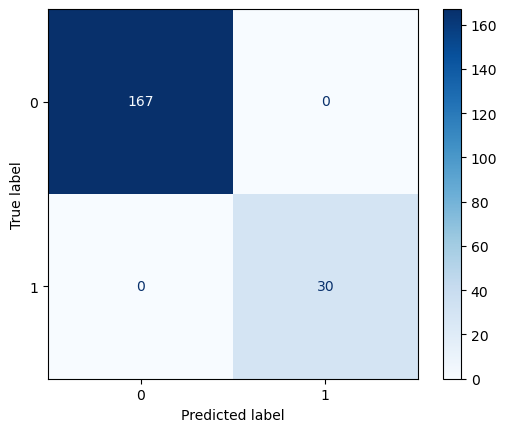

In [244]:
cm_display2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
cm_display2.plot(cmap='Blues', values_format='d')
cm_display2